In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import SVDpp
from surprise import SlopeOne
from surprise import CoClustering
from surprise import NormalPredictor
from surprise import SVDpp

In [2]:
csv_path = os.path.join("../data/csv/beer_reviews.csv")
TextFileReader = pd.read_csv(csv_path, chunksize=1000)  # the number of rows per chunk

dfList = []
for df in TextFileReader:
    dfList.append(df)

df = pd.concat(dfList,sort=False)

# df = pd.DataFrame()
# for chunk in pd.read_csv(csv_path, header=None, chunksize=1000):
#     df = pd.concat([df, chunk], ignore_index=True)


In [3]:
# The algorithm below reduces the memory size of a dataframe
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [4]:
props = df
props, NAlist = reduce_mem_usage(props)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 133.15400886535645  MB
******************************
Column:  brewery_id
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  review_time
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  review_overall
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  review_aroma
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  review_appearance
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  review_palate
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  review_taste
dtype before:  float64
dtype after:  float32
******************************
******************************
Co

In [5]:
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  uint16 
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  uint32 
 3   review_overall      1586614 non-null  float32
 4   review_aroma        1586614 non-null  float32
 5   review_appearance   1586614 non-null  float32
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float32
 9   review_taste        1586614 non-null  float32
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1586614 non-null  float32
 12  beer_beerid         1586614 non-null  uint32 
dtypes: float32(6), object(4), uint16(1), uint32(2)
memory usage: 75.7+ MB


In [7]:
#create dataframe in format that Surprise uses
# The columns must correspond to user id, item id and ratings. Names are irrelevent
columns =['brewery_id','brewery_name','review_time','review_aroma','review_appearance','beer_style','review_palate',
          'review_taste','beer_name', 'beer_abv']
df2 = df
df2.drop(columns, inplace=True, axis=1)
df2.head()

,review_overall,review_profilename,beer_beerid
0,1.5,stcules,47986
1,3.0,stcules,48213
2,3.0,stcules,48215
3,3.0,stcules,47969
4,4.0,johnmichaelsen,64883


In [8]:
# Check upper rating 
df2.max(axis=0)['review_overall']

5.0

In [9]:
# Check lower rating
df2.min(axis=0)['review_overall']

0.0

In [10]:
# Remove NAN
df2 = df2.dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586266 entries, 0 to 1586613
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   review_overall      1586266 non-null  float32
 1   review_profilename  1586266 non-null  object 
 2   beer_beerid         1586266 non-null  uint32 
dtypes: float32(1), object(1), uint32(1)
memory usage: 30.3+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x3E3FF118>,
      dtype=object)

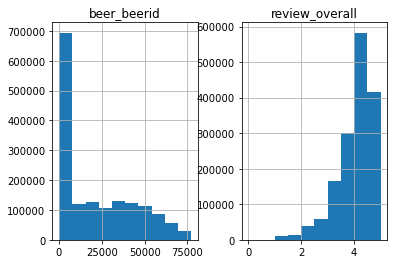

In [15]:
# Lets look at the data now as histograms
df2.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x3CBD6AF0>]],
      dtype=object)

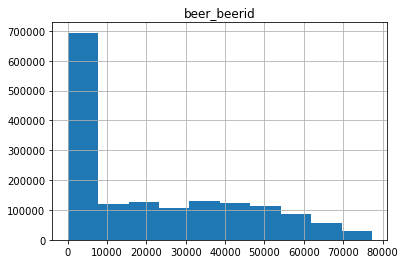

In [17]:
df2.hist(column='beer_beerid')

In [11]:
# A reader is needed but only the rating_scale param is requiered.
reader=Reader(rating_scale=(0,5))
# The columns must correspond to user id, item id and ratings (in that order). Names are irrelevent
data = Dataset.load_from_df(df2[['review_profilename', 'beer_beerid', 'review_overall']], reader)

### Run a test/trainset using SVD with df2 (single user entries and all beers included)

In [12]:
# sample random trainset and testset method
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE and MAE
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.6099
MAE:  0.4562


0.45622699619345514

In [24]:
# Lets try to reduce/clean the dataset some more. Remove all reviews if person only rated less than 10 beers
df3 = df2.groupby('review_profilename').filter(lambda x: len(x) > 10)
df3.shape

(1521753, 3)

In [25]:
# Remove beers with less than 50 reviews
df3 = df3.groupby('beer_beerid').filter(lambda x: len(x) > 50)
df3.shape

(1199517, 3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x3D399A90>,
      dtype=object)

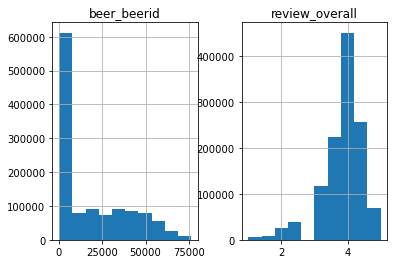

In [26]:
df3.hist()

### Run a test/trainset using SVD with df3's cleaned dataset

In [27]:
# Rerun using the new df3 reduced dataset and the test/train method
# sample random trainset and testset method
# test set is made of 25% of the ratings.

data = Dataset.load_from_df(df3[['review_profilename', 'beer_beerid', 'review_overall']], reader)

trainset, testset = train_test_split(data, test_size=.25)

algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE and MAE
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.5823
MAE:  0.4364


0.4363839967358215

#### Run SVD with 5 fold cross validate with df3's cleaned dataset

In [28]:
# Five fold cross validation method
# Using the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5832  0.5823  0.5830  0.5817  0.5797  0.5820  0.0012  
MAE (testset)     0.4360  0.4363  0.4362  0.4357  0.4342  0.4357  0.0008  
Fit time          57.82   60.49   58.04   60.61   61.97   59.79   1.60    
Test time         2.37    2.64    2.15    3.11    2.47    2.55    0.32    


{'test_rmse': array([0.58321746, 0.58233474, 0.58300113, 0.58168409, 0.57974526]),
 'test_mae': array([0.43603956, 0.43633456, 0.43619084, 0.43571879, 0.43416781]),
 'fit_time': (57.82361030578613,
  60.49331212043762,
  58.035738706588745,
  60.61064672470093,
  61.97307825088501),
 'test_time': (2.3706092834472656,
  2.6379356384277344,
  2.1450321674346924,
  3.1093928813934326,
  2.467724323272705)}

In [ ]:
# 5-fold CV took a long time to run!  Results with smaller dataset not as good as df2

### Try the KNN algorithm

In [ ]:
# The KNN algorithm creates a very large array and cannot be ran with a datafile as large as df3
# so lets reduce it!

In [46]:
# Reduce/clean the dataset some more. Randomly remove rows to get the dataset under 250K rows
df4 = df3.sample(n=250000)
# Lets try to reduce/clean the dataset some more. Remove all beers rated less than 20 times
df4 = df4.groupby('beer_beerid').filter(lambda x: len(x) > 20)
df4.shape

(166424, 3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x44580670>,
      dtype=object)

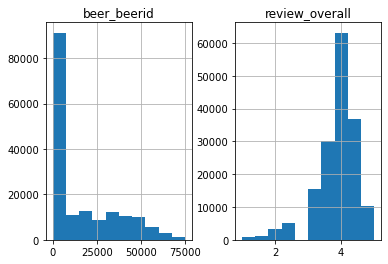

In [47]:
df4.hist()

In [48]:
# sample random trainset and testset method
# test set is made of 25% of the ratings.

data = Dataset.load_from_df(df4[['review_profilename', 'beer_beerid', 'review_overall']], reader)

trainset, testset = train_test_split(data, test_size=.25)

sim_options = {'name': 'pearson',
               'user_based': False
               }

# We'll use KNN.
algo = KNNBasic(sim_options=sim_options)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.fit(trainset).test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.7358


0.735766045890914

#### Create algorithm to test different models with df4 using cross validate

In [ ]:
# Now we have a smaller dataset that doesnt give memory erros lets try different algorithms
# with df4!

In [60]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NormalPredictor(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.593218,84.538909,3.584498
SVD,0.597754,7.110925,0.406649
SlopeOne,0.652928,1.061932,3.649950
CoClustering,0.683828,4.394435,0.467213
NormalPredictor,0.956019,0.341648,0.818544


In [6]:
# Looks like SVD is the one to use!  It performs well with the large and small dataset and has good fit time
# may be worth looking at SlopeONe also.  THe SVDpp has good fit but very slow fit time.


In [10]:
# # Output File (CSV)
# filename = "ba_beerstyles.csv"
# # Save and make sure to set index to False
# path = os.path.join("../data/csv/"+filename)   
# df_final.to_csv(path,index = False)